In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import regex as re
import networkx as nx
import random
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import plotly.graph_objects as go
from PIL import Image
from scipy.stats import spearmanr

from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity

from functions import calculate_monthly_velocities_cosine, get_similarities, get_matrix

In [2]:
# Read the Parquet file into an Arrow Table
tweets = pq.read_table('data/tweets_light.parquet')
retweets = pq.read_table('data/retweets_light.parquet')
users = pq.read_table('data/users_tw+rt_light.parquet')

# Convert the Arrow Table to a Pandas DataFrame
df_tweets = tweets.to_pandas()
df_retweets = retweets.to_pandas()
df_users = users.to_pandas()

In [ ]:
#convert column data types
df_tweets['author_id'] = df_tweets['author_id'].astype(int)
df_users['id'] = df_users['id'].astype(float)

#merge df_tweets and df_users
df_users_tweets = pd.merge(df_tweets, df_users, left_on="author_id", right_on="id")

In [ ]:
df_users_tweets.drop(columns="id_y", inplace = True)
df_users_tweets = df_users_tweets.rename(columns={"created_at_x":"tweet_created_at", "id_x":"original_post_id", "created_at_y":"account_created_at", "name":"author_name", "username":"author_username"})

In [ ]:
#merge df_user_tweets and df_retweets on original_post_id and post_id
df_all = pd.merge(df_users_tweets, df_retweets, left_on="original_post_id", right_on="post_id")
df_all.drop(columns=["post_id", "url", "location", "verified"], inplace = True)

In [ ]:
#convert column data types
df_all['original_post_id'] = df_all['original_post_id'].astype(int)
df_all['retweeter_id'] = df_all['retweeter_id'].astype(int)

In [ ]:
df_all = df_all.drop(columns=['lang', 'text',
       'possibly_sensitive', 'referenced_id', 'reference_type',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'public_metrics.retweet_count',
       'account_created_at', 'description','name'])

In [ ]:
df_all.dropna(inplace=True)

In [ ]:
df_all.describe()

,tweet_created_at,original_post_id,author_id,retweeter_id
count,29235029,2.923503e+07,2.923503e+07,2.923503e+07
mean,2020-06-25 17:59:32.733049,1.276245e+18,1.185610e+17,4.458498e+17
min,2017-12-31 23:11:09,9.476212e+17,5.893702e+06,1.200000e+01
25%,2019-03-09 14:13:47,1.104400e+18,1.406026e+07,5.754239e+08
50%,2020-06-02 07:19:34,1.267752e+18,1.507257e+08,2.895642e+09
75%,2021-09-21 22:00:00,1.440548e+18,1.024976e+09,9.851892e+17
max,2022-12-31 22:19:02,1.609328e+18,1.555225e+18,1.666974e+18
std,NaN,1.928046e+17,3.106293e+17,5.506337e+17


In [ ]:
print("df has shape:",df_all.shape)

df has shape: (29235029, 6)


In [ ]:
df_all.head()

,tweet_created_at,original_post_id,author_id,author_name,author_username,retweeter_id
0,2018-12-31 22:46:18,1079886497279561728,622354597,Salvo Di Grazia,MedBunker,951848540
1,2018-12-31 22:46:18,1079886497279561728,622354597,Salvo Di Grazia,MedBunker,135554444
2,2018-12-31 22:46:18,1079886497279561728,622354597,Salvo Di Grazia,MedBunker,433418060
3,2018-12-31 22:46:18,1079886497279561728,622354597,Salvo Di Grazia,MedBunker,1668533642
4,2018-12-31 22:46:18,1079886497279561728,622354597,Salvo Di Grazia,MedBunker,1623208790


In [3]:
checkpoint_path = "data/df_checkpoint.parquet"

# load data from checkpoint or save
if os.path.exists(checkpoint_path):
    print("Loading df from checkpoint...")
    df_all = pd.read_parquet(checkpoint_path)
else:
    print("Saving df to checkpoint...")
    df_all.to_parquet(checkpoint_path)

Loading df from checkpoint...


### Get Statistcs

In [4]:
years = df_all["tweet_created_at"].dt.year.unique()
years = [y for y in years if y != 2017]

In [5]:
month_mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

In [6]:
def get_month(month_num:int, year:int):
    '''
    get 1 month of data from df (all data)
    '''
    return df[df['tweet_created_at'].dt.to_period('M') == f'{year}-{month_num}']

In [7]:
def author_mapping(month_name:str):

        '''
        This function outputs the top and bottom 10 similarities for a specific month.
        '''
        author_to_index = {author: j for j, author in enumerate(month_data[month_name]['author_id'].unique())}

        ## Create a mapping from author_id to author_name
        author_id_to_name = month_data[month_name].set_index('author_id')['author_name'].to_dict()

        #  Map author IDs to names
        author_names = [author_id_to_name[author] for author in author_to_index.keys()]

        # Create a DataFrame for the similarities matrix
        similarities_df = similarities_copy[month_name]
        similarities_df.columns = author_names
        similarities_df.index = author_names

In [8]:
year_stats = {}

for year in years:

    # create a filtered dataframe for the current year
    df = df_all[df_all["tweet_created_at"].dt.year == year]
    
    month_data = {}

    for k, v in month_mapping.items():
        month_data[v] = get_month(month_num=k, year=year)

    month_matrices = {}

    for k, v in month_data.items():
        month_matrices[k] = get_matrix(month_data[k])

    similarities = {}

    for k, v in tqdm(month_matrices.items(), desc=f"Calculating similarities for {year}"):
        similarities[k] = get_similarities(month_matrix=month_matrices[k], metric='cosine')
    
    similarities_copy = similarities.copy()

    # map author names to rows and columns
    for month in similarities_copy.keys():
        author_mapping(month_name=month)

    # merge similarities using full outer join
    merged_similarities = pd.DataFrame()

    for month, similarity_df in similarities_copy.items():
        similarity_df.columns = [f"{col}_{month}" for col in similarity_df.columns]
        merged_similarities = pd.merge(
            merged_similarities, similarity_df, how="outer", left_index=True, right_index=True).fillna(0) # Add suffix manually to avoid collision
            
    merged_similarities = merged_similarities.T

    month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

    avg_std_per_month = {}
    avg_mean_per_month = {}

    for month in month_names:
        filtered = merged_similarities[merged_similarities.index.str.contains(f'_{month}', case=False)].sort_index()
        std_per_column = filtered.std(axis=0, skipna=True)
        mean_per_column = filtered.mean(axis=0, skipna=True)
        avg_std_per_month[month] = std_per_column.mean()
        avg_mean_per_month[month] = mean_per_column.mean()

    # Calculate velocities using cosine distance
    velocities_cosine_full = calculate_monthly_velocities_cosine(merged_similarities, month_names)

    # Convert the velocities_cosine dictionary into a DataFrame
    velocities_df_full = pd.concat(velocities_cosine_full, axis=0)

    # Reset the index to make the month pairs a column
    velocities_df_full.reset_index(inplace=True)

    # Rename the columns for clarity
    velocities_df_full.columns = ['Month Pair', 'Node', 'Velocity']

    # Define the desired column order
    column_order = [
        'January-February', 'February-March', 'March-April', 'April-May', 
        'May-June', 'June-July', 'July-August', 'August-September', 
        'September-October', 'October-November', 'November-December'
    ]

    # Pivot the DataFrame to make month pairs the column names
    velocities_df_full = velocities_df_full.pivot(index='Node', columns='Month Pair', values='Velocity')

    # Reorder the columns
    velocities_df_full = velocities_df_full[column_order]

    # Reset the index to make it more readable (optional)
    velocities_df_full.reset_index(inplace=False)

    # Prepare velocity means and stds for the same x-axis
    veloc_means_arr = np.array([velocities_df_full[col].mean(skipna=True) for col in column_order])
    veloc_stds_arr = np.array([velocities_df_full[col].std(skipna=True) for col in column_order])

    modularity_per_month = {}

    for month in month_names:
        # Create the graph for the month
        filtered = merged_similarities[merged_similarities.index.str.contains(f'_{month}', case=False)].sort_index()
        filtered.index = filtered.index.str.replace(r'_[^_]+$', '', regex=True)

        filtered = filtered.loc[filtered.index, filtered.index]
        G = nx.from_pandas_adjacency(filtered)
        
        # Louvain communities and modularity
        communities = louvain_communities(G, weight='weight', seed=42) # weight='weight' as values from the filtered variable
        mod = modularity(G, communities, weight='weight')
        modularity_per_month[month] = mod

    consecutive_modularity_averages = []
    consecutive_month_pairs = []

    months = list(modularity_per_month.keys())
    modularities = list(modularity_per_month.values())

    for i in range(len(months) - 1):
        avg = (modularities[i] + modularities[i + 1]) / 2
        consecutive_modularity_averages.append(avg)
        consecutive_month_pairs.append(f"{months[i]}-{months[i+1]}")

    # Store stats for this year, now including avg_std_per_month and avg_mean_per_month
    year_stats[year] = (
        veloc_means_arr,
        veloc_stds_arr,
        consecutive_modularity_averages,
        avg_std_per_month,
        avg_mean_per_month
    )

# After the loop, create a DataFrame
stats_df = pd.DataFrame([
    {
        'year': year,
        'veloc_means_arr': veloc_means_arr,
        'veloc_stds_arr': veloc_stds_arr,
        'consecutive_modularity_averages': mod_avgs,
        'sim_avg_std_per_month': avg_std_per_month,
        'sim_avg_mean_per_month': avg_mean_per_month
    }
    for year, (veloc_means_arr, veloc_stds_arr, mod_avgs, avg_std_per_month, avg_mean_per_month) in year_stats.items()
])

Calculating similarities for 2022: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


In [9]:
stats_df.head()

,year,veloc_means_arr,veloc_stds_arr,consecutive_modularity_averages,sim_avg_std_per_month,sim_avg_mean_per_month
0,2018,"[0.051214008463286664, 0.05491317332766376, 0....","[0.05299022692465565, 0.0890761021085431, 0.07...","[0.5680653341085709, 0.5783983258293317, 0.569...","{'January': 0.05438617324026037, 'February': 0...","{'January': 0.01591008195557077, 'February': 0..."
1,2019,"[0.04648863740507882, 0.04981199329265121, 0.0...","[0.05207777475178581, 0.05488856551853223, 0.0...","[0.5111162670097047, 0.5347026476729275, 0.551...","{'January': 0.06722109384721667, 'February': 0...","{'January': 0.024296180851497488, 'February': ..."
2,2020,"[0.04632057040232594, 0.04101189044380686, 0.0...","[0.03383944252611081, 0.02733676694251247, 0.0...","[0.51963245106091, 0.4870908112851826, 0.47975...","{'January': 0.06090538976340603, 'February': 0...","{'January': 0.020997684324814293, 'February': ..."
3,2021,"[0.03419731597636642, 0.03098708858310372, 0.0...","[0.0330341457502581, 0.02991915562206083, 0.04...","[0.5112193727677552, 0.5272539271862956, 0.530...","{'January': 0.06033276184962287, 'February': 0...","{'January': 0.020772162064979664, 'February': ..."
4,2022,"[0.039197716300539656, 0.04606048233657261, 0....","[0.028935671284474378, 0.03648860027168035, 0....","[0.5118907310648402, 0.5256815905362684, 0.542...","{'January': 0.05742891722244035, 'February': 0...","{'January': 0.018737144726381, 'February': 0.0..."


In [3]:
stats_checkpoint_path = "stats_checkpoint.parquet"

# load data from checkpoint or save
if os.path.exists(stats_checkpoint_path):
    print("Loading stats_df from checkpoint...")
    stats_df = pd.read_parquet(stats_checkpoint_path)
else:
    print("Saving stats_df to checkpoint...")
    stats_df.to_parquet(stats_checkpoint_path, index=False)

Loading stats_df from checkpoint...


### Plot merged stats values

In [4]:
def plot_combined_years(yearly_data, years, column_order):
    """
    yearly_data: dict of {year: (means_arr, stds_arr, consecutive_modularity_averages, consecutive_month_pairs)}
    years: list of years to plot
    column_order: list of all month-pair labels in order
    """
    # Concatenate data
    all_means = []
    all_stds = []
    all_modularities = []
    all_month_pairs = []
    for year in years:
        means_arr, stds_arr, modularity_avgs, month_pairs, sim_avg_std_per_month, sim_avg_mean_per_month = yearly_data[year]
        all_means.extend(means_arr)
        all_stds.extend(stds_arr)
        all_modularities.extend(modularity_avgs)
        all_month_pairs.extend([f"{year}-{mp}" for mp in month_pairs])

    fig, ax1 = plt.subplots(figsize=(24, 6))
    ax1.plot(all_month_pairs, all_modularities, marker='o', linestyle='-', color='purple', label='Avg. Modularity')
    ax1.set_xlabel('Year-Month Pair')
    ax1.set_ylabel('Average Modularity', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.set_xticks(range(len(all_month_pairs)))
    ax1.set_xticklabels(all_month_pairs, rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(all_month_pairs, all_means, marker='o', linestyle='--', color='g', label='Mean Velocity')
    ax2.fill_between(range(len(all_month_pairs)), np.array(all_means) - np.array(all_stds), np.array(all_means) + np.array(all_stds), color='green', alpha=0.15, label='Velocity Mean ± Std. Dev.')
    ax2.set_ylabel('Velocity', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', bbox_to_anchor=(1.02, 0.5), borderaxespad=6)

    plt.title('Combined Years: Average Louvain Modularity, Similarity, and Velocity Statistics per Month Pair')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('combined_2018_2022_merged.png')
    plt.show()

In [5]:
# Define the desired column order
column_order = [
    'January-February', 'February-March', 'March-April', 'April-May', 
    'May-June', 'June-July', 'July-August', 'August-September', 
    'September-October', 'October-November', 'November-December'
]

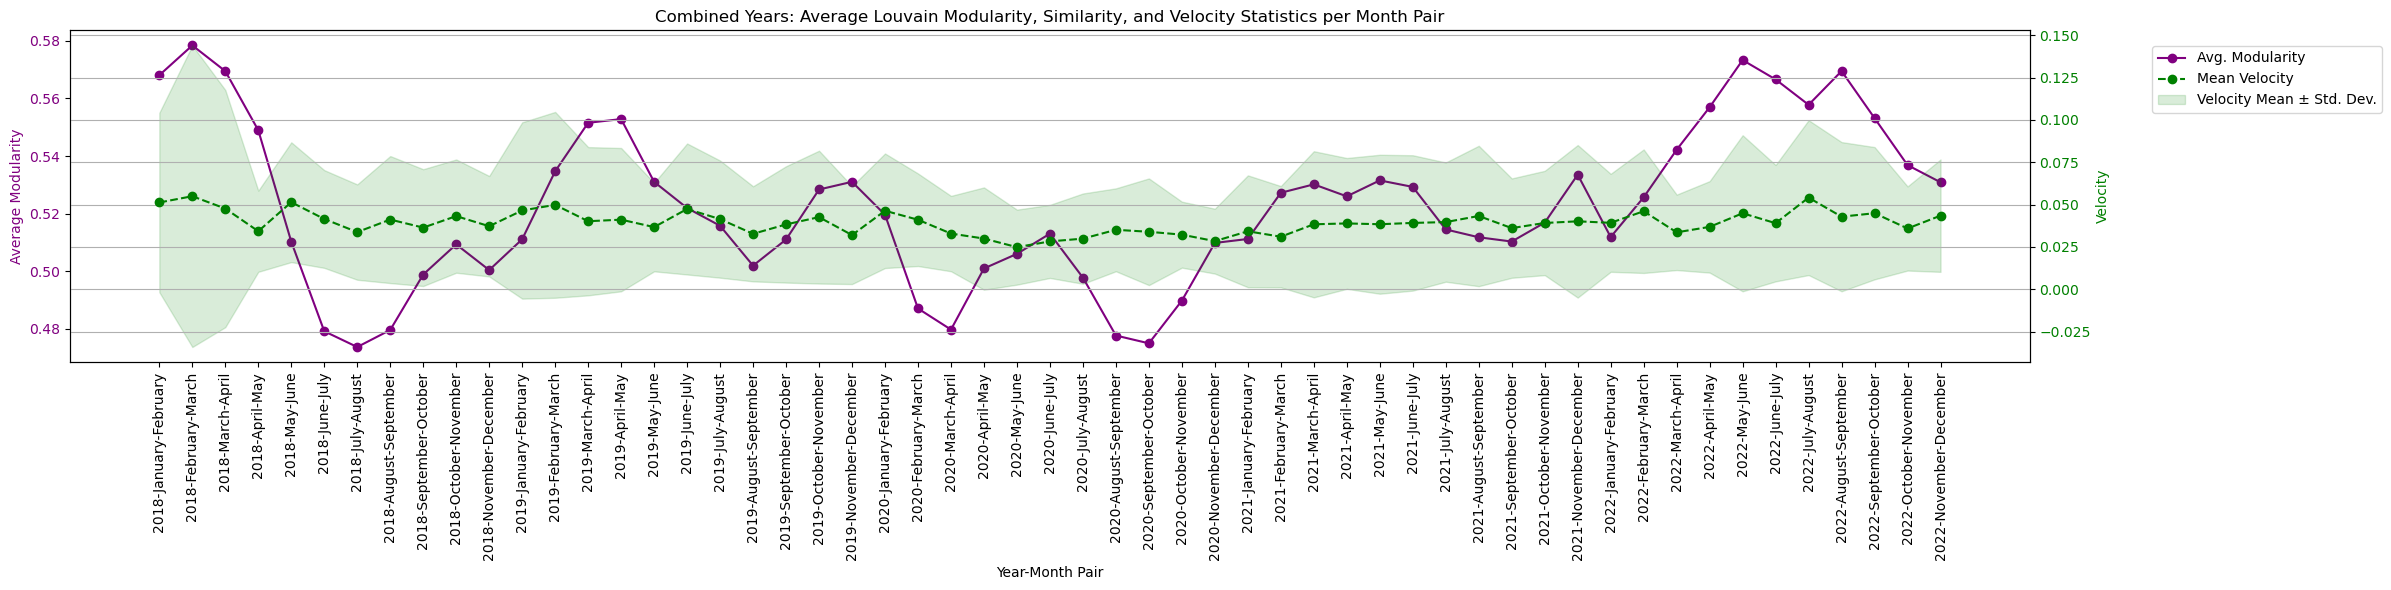

In [101]:
# Prepare data_per_year from stats_df
data_per_year = {}
for _, row in stats_df.iterrows():
    # Use column_order as the month_pairs for all years (or adapt if you have per-year pairs)
    data_per_year[row['year']] = (
        row['veloc_means_arr'],
        row['veloc_stds_arr'],
        row['consecutive_modularity_averages'],
        column_order,  # This is used as month_pairs
        row['sim_avg_std_per_month'],
        row['sim_avg_mean_per_month']
    )

# List of years to plot
years = list(stats_df['year'])

# Call the plotting function
plot_combined_years(data_per_year, years, column_order)

In [102]:
stats_df_copy = stats_df.copy()

In [116]:
stats_df_copy_renamed = stats_df_copy.rename(columns={
    'veloc_means_arr': 'Velocity Means',
    'veloc_stds_arr': 'Velocity STDs',
    'consecutive_modularity_averages': 'Modularity Average',
    'sim_avg_std_per_month': 'AVG STD of Similarity per Month',
    'sim_avg_mean_per_month': 'AVG Mean of Similarity per Month'
})

In [118]:
# Function to flatten column values to a list of floats
def flatten_column(col):
    flattened = []
    for val in col:
        if isinstance(val, dict):
            flattened.extend([float(v) for v in val.values()])
        elif isinstance(val, (list, np.ndarray)):
            flattened.extend([float(v) for v in val])
        else:
            flattened.append(float(val))
    return flattened

In [120]:
# Flatten and collect all columns except 'year'
flattened_cols = {}
for col in stats_df_copy_renamed.columns:
    if col == 'year':
        continue
    flattened_vals = flatten_column(stats_df_copy_renamed[col])
    flattened_cols[col] = flattened_vals

# Align by shortest length
min_len = min(len(v) for v in flattened_cols.values())
aligned_cols = {k: v[:min_len] for k, v in flattened_cols.items()}

# Build aligned DataFrame
flat_df = pd.DataFrame(aligned_cols)

# Compute Spearman correlation and p-values using scipy
corr_matrix, pval_matrix = spearmanr(flat_df)

# Convert to DataFrames for better readability
spearman_corr_df = pd.DataFrame(corr_matrix, index=flat_df.columns, columns=flat_df.columns)
spearman_pval_df = pd.DataFrame(np.round(pval_matrix, 4), index=flat_df.columns, columns=flat_df.columns)

In [121]:
display(spearman_corr_df)
display(spearman_pval_df)

,Velocity Means,Velocity STDs,Modularity Average,AVG STD of Similarity per Month,AVG Mean of Similarity per Month
Velocity Means,1.000000,0.788745,0.433983,-0.361688,-0.400000
Velocity STDs,0.788745,1.000000,0.532251,-0.255844,-0.302525
Modularity Average,0.433983,0.532251,1.000000,-0.206277,-0.310173
AVG STD of Similarity per Month,-0.361688,-0.255844,-0.206277,1.000000,0.871789
AVG Mean of Similarity per Month,-0.400000,-0.302525,-0.310173,0.871789,1.000000


,Velocity Means,Velocity STDs,Modularity Average,AVG STD of Similarity per Month,AVG Mean of Similarity per Month
Velocity Means,0.0000,0.0000,0.0009,0.0067,0.0025
Velocity STDs,0.0000,0.0000,0.0000,0.0594,0.0248
Modularity Average,0.0009,0.0000,0.0000,0.1308,0.0212
AVG STD of Similarity per Month,0.0067,0.0594,0.1308,0.0000,0.0000
AVG Mean of Similarity per Month,0.0025,0.0248,0.0212,0.0000,0.0000


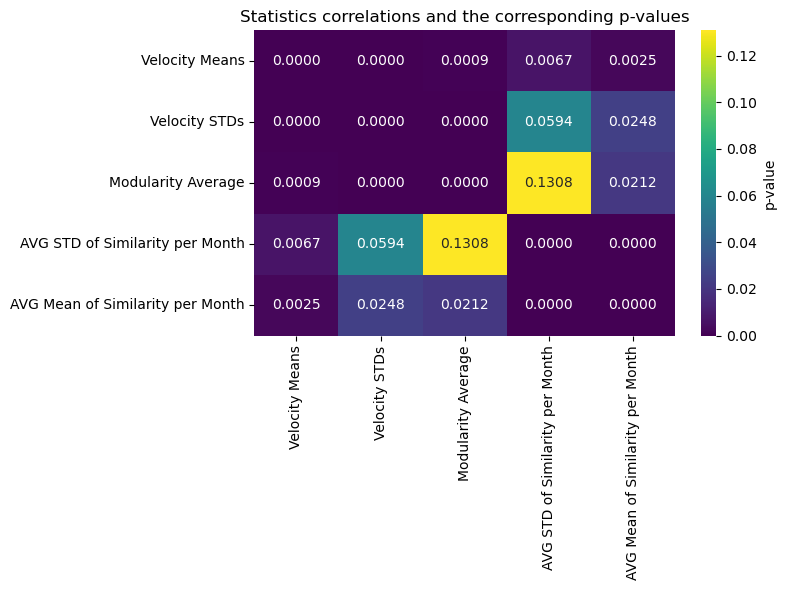

In [131]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    spearman_pval_df,
    annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'p-value'}
)
plt.title("Statistics correlations and the corresponding p-values")
plt.tight_layout()
plt.savefig('correlations_heatmap.png')
plt.show()